# Approximating functions with deep ReLU networks
*Practical session for the course [Mathematic of deep learning](http://www.lsf.tu-berlin.de/qisserver/servlet/de.his.servlet.RequestDispatcherServlet?state=verpublish&status=init&vmfile=no&publishid=233449&moduleCall=webInfo&publishConfFile=webInfo&publishSubDir=veranstaltung), October 2019.*
The content is mostly based on [D. Yarotsky, 2017](https://www.sciencedirect.com/science/article/pii/S0893608017301545).

## Part III: The class of target functions

In this part we will discuss the set of functions that can be well approximated by deep ReLU networks.

In general, we consider functions in the **Sobolev space**

$$ W^{r,\infty}\left((0,1)^d\right) $$

that is functions on the $d$-dimensional unit cube with all weak derivates up to order $r$ in $L^\infty$.

Note that the Sobolev embedding theorem tells us that there is an **embedding** of Sobolev spaces to Hölder spaces

$$ W^{r, p}\left((0,1)^d\right) \hookrightarrow C^{k, \alpha}\left((0,1)^d\right) $$

if we have

$$ \frac{1}{p} - \frac{r}{d} = -\frac{k+\alpha}{d}, \quad 0<\alpha\leq 1 $$

which in our case of $p=\infty$ yields

$$ W^{r, \infty}\left((0,1)^d\right) \hookrightarrow C^{r-1, 1}\left((0,1)^d\right). $$

So we can simply think of $r-1$ times **continously differentiable** functions whose derivatives of order $r-1$ are **Lipschitz continuous**.

The approximation rates derived by Yarotsky depend on the regularity $r$ and dimension $d$ and are valid for the unit balls $F^{r, d}$ in $W^{r, \infty}\left((0,1)^d\right)$.

For the purpose of visualizations we restrict ourself to the two-dimensional case $d=2$ from now on. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from ipywidgets import HBox, VBox, IntSlider, FloatSlider, interactive_output
plt.rcParams['figure.figsize'] = (15,6)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

### Bernstein polynomials

The network architectures constructed by Yarotsky first approximate polynomials and then build local Taylor expansions to approximate more general functions. So let us start with some polymials, for example **Berstein polynomials** on $(0,1$).

These are defined as

$$ b_{k, n}(x) = {n\choose k} x^k (1-x)^{n-k},\quad k=0, 1, \dots, n, \quad n\in\mathbb{N}.$$

In [6]:
# numpy vectorized Bernstein polynomial
def bernstein(x, k, n):
    assert (0<=k and k<=n), \
        'Berstein polynomial only defined for 0<=k<=n, got (n, k)=({},{}) instead'.format(n,k)
    return binom(n, k)*(x**k)*((1-x)**(n-k))

# numpy vectorized derivative of Bernstein polynomials
def Dbernstein(x, k, n):
    assert (0<=k and k<=n), \
        'Berstein polynomial only defined for 0<=k<=n, got (n, k)=({},{}) instead'.format(n,k)
    if n==0 or k==0:
        b1 = 0*x
    else:
        b1 = bernstein(x, k-1, n-1)
    if n==0 or k==n:
        b2 = 0*x
    else:
        b2 = bernstein(x, k, n-1)
    return n*(b1 - b2)

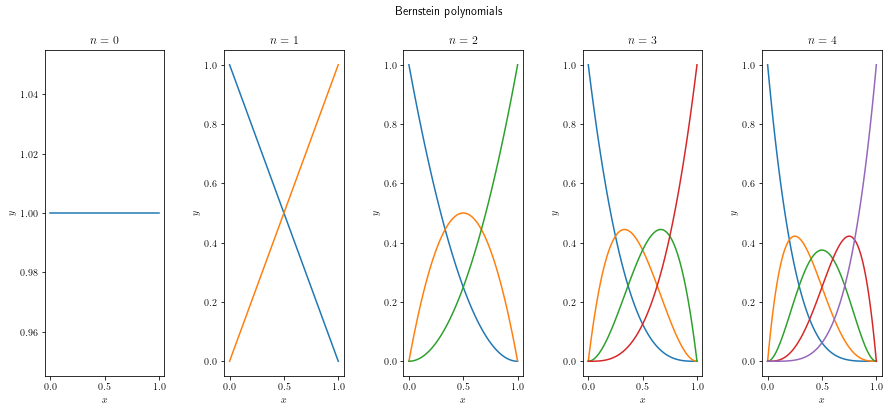

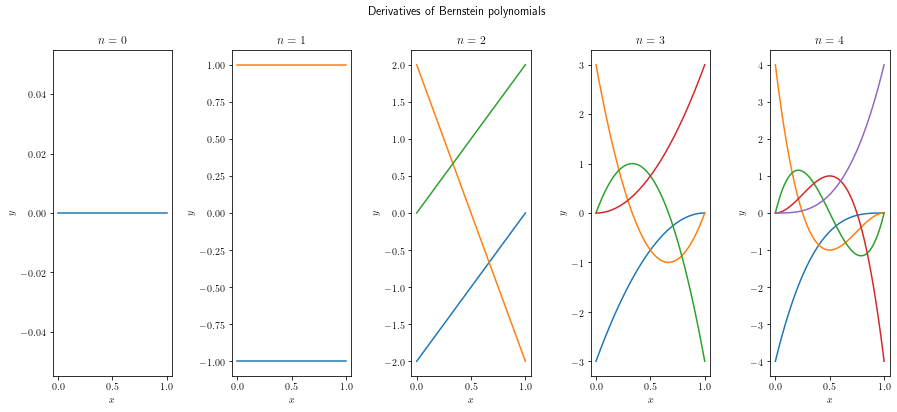

In [7]:
# setup domain and plotting grid points
domain = [0.0, 1.0]
resolution = 100
xs = np.linspace(domain[0], domain[1], resolution)

# plot various Bernstein polynomials
plt.figure(figsize=(15,6))
for n in range(5):
    plt.subplot(1,5,n+1)
    for k in range(n+1):
        plt.plot(xs, bernstein(xs, k, n))
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.title('$n={}$'.format(n))
    plt.subplots_adjust(wspace=0.5)
    plt.suptitle('Bernstein polynomials')

# plot derivatives of various Bernstein polynomials    
plt.figure(figsize=(15,6))
for n in range(5):
    plt.subplot(1,5,n+1)
    for k in range(n+1):
        plt.plot(xs, Dbernstein(xs, k, n))
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.title('$n={}$'.format(n))
    plt.subplots_adjust(wspace=0.5)
    plt.suptitle('Derivatives of Bernstein polynomials')
        

### Berstein polynomial tensor products

For the two-dimensional case we simple take **tensor products** of one-dimensional Berstein polynomials

$$ b_{(k_x, k_y), (n_x, n_y)}(x, y) = b_{k_x, n_x}(x) b_{k_y, n_y} (y).$$

In [8]:
# numpy vectorized Bernstein polynomial tensor products
def bernstein2d(xgrid, ygrid, k, n):
    assert (np.all(0<=np.asarray(k)) and np.all(np.asarray(k)<=np.asarray(n))), \
        'Berstein polynomial only defined for 0<=k<=n, got (n, k)=({},{}) instead'.format(n,k)
    return bernstein(xgrid, k[0], n[0])*bernstein(ygrid, k[1], n[1])

# numpy vectorized partial derivatives of Bernstein polynomial tensor products
def Dbernstein2d(xgrid, ygrid, k, n):
    assert (np.all(0<=np.asarray(k)) and np.all(np.asarray(k)<=np.asarray(n))), \
        'Berstein polynomial only defined for 0<=k<=n, got (n, k)=({},{}) instead'.format(n,k)
    Dx = Dbernstein(xgrid, k[0], n[0])*bernstein(ygrid, k[1], n[1])
    Dy = bernstein(xgrid, k[0], n[0])*Dbernstein(ygrid, k[1], n[1])
    return (Dx, Dy)

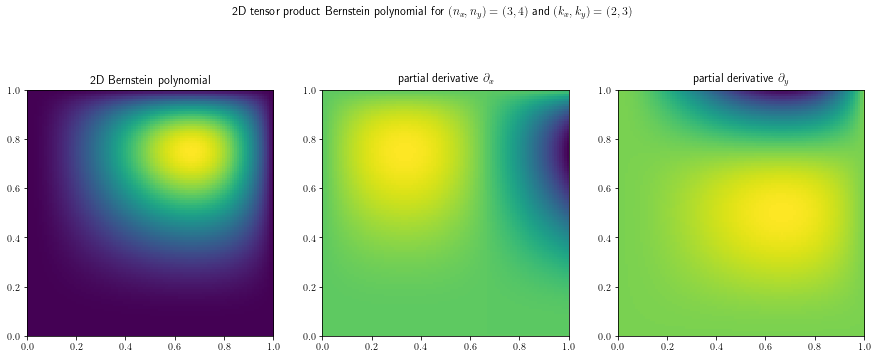

In [9]:
# setup domain and plotting grid points
domain = [0.0, 1.0, 0.0, 1.0]
resolution = 100
xs = np.linspace(domain[0], domain[1], resolution)
ys = np.linspace(domain[0], domain[1], resolution)
xgrid, ygrid = np.meshgrid(xs, ys)
n = np.asarray([3, 4])
k = np.asarray([2, 3])


# plot 2D Bernstein polynomials and partial derivatives
zs = bernstein2d(xgrid, ygrid, k, n)
zsDx, zsDy = Dbernstein2d(xgrid, ygrid, k, n)

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(zs, extent=domain, origin='lower')
plt.title('2D Bernstein polynomial')

plt.subplot(1,3,2)
plt.imshow(zsDx, extent=domain, origin='lower')
plt.title('partial derivative $\partial_x$')


plt.subplot(1,3,3)
plt.imshow(zsDy, extent=domain, origin='lower')
plt.title('partial derivative $\partial_y$')

plt.suptitle('2D tensor product Bernstein polynomial for $(n_x, n_y)=(3, 4)$ and $(k_x, k_y)=(2, 3)$');

### Functions with limited regularity

Using the Bernstein polynomials described above will not allow us to see the dependence of approximation rates on the regularty $r$ as all polynomials are infinitely regular. Therefore, we will add functions with **limited regularity** to our family of target functions.

For this consider the **signum** function

$$ \mathrm{sign}(x) = \begin{cases} 1\quad &, x>0\\ 0\quad &, x=0\\ -1\quad &, x<0 \end{cases} $$

which is not even continuous but integrable over $(0,1)$. **Integrating** this function $r$ times, we obtain the function

$$ \tilde{h}_r(x) = \frac{1}{r!} x^r \mathrm{sign}(x) $$

which is $r-1$ times continuously differentiable and the $(r-1)$-th derivative is Lipschitz continuous. The problematic point is of course $x=0$, so in order to have this point within our domain of interet $(0,1)$ we can simply consider the scaled and shifted function 

$$ h_r(x) = \tilde{h}_r\left(2x-1\right). $$

Then $h_r\in W^{r,\infty}\left((0,1)\right)$ but $h_r\notin W^{r+1,\infty}\left((0,1)\right)$.

In [10]:
#numpy vectorized integrated sign function
def signpoly(x, r):
    return 1/np.math.factorial(r)*np.power(x, r)*np.sign(x)

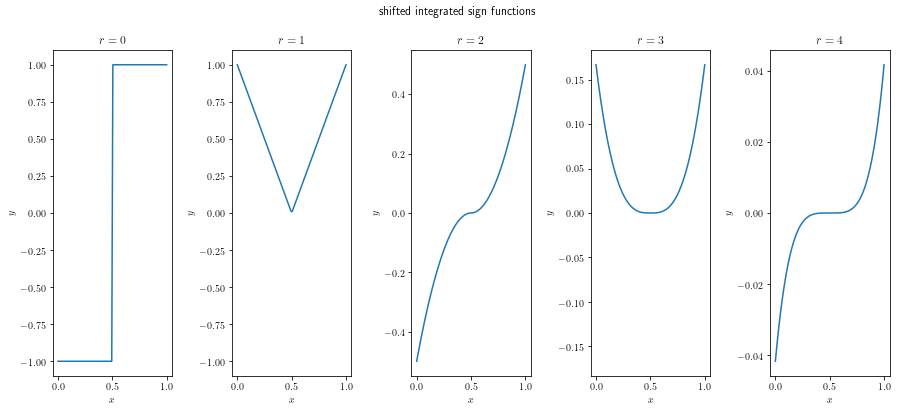

In [11]:
# setup domain and plotting grid points
domain = [0.0, 1.0]
resolution = 100
xs = np.linspace(domain[0], domain[1], resolution)

# plot various Bernstein polynomials
plt.figure(figsize=(15,6))
for r in range(5):
    plt.subplot(1,5,r+1)
    plt.plot(xs, signpoly(2*xs-1, r))
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.ylim(-1.1/np.math.factorial(r), 1.1/np.math.factorial(r))
    plt.title('$r={}$'.format(r))
plt.subplots_adjust(wspace=0.5)
plt.suptitle('shifted integrated sign functions');

Again we simply use tensor products to extend this to two dimensions

$$ h_{r_x, r_y}(x, y) = h_{r_x}(x) h_{r_y}(y) .$$

In [12]:
# setup domain and plotting grid points
domain = [0.0, 1.0, 0.0, 1.0]
resolution = 100
xs = np.linspace(domain[0], domain[1], resolution)
ys = np.linspace(domain[0], domain[1], resolution)
xgrid, ygrid = np.meshgrid(xs, ys)

# create sliders for interactive plot
r1_slider = IntSlider(1.0, min=0.0, max=5.0, description='$r_x$')
r2_slider = IntSlider(1.0, min=0.0, max=5.yy<0, description='$r_y$')
c1_slider = FloatSlider(0.0, min=-1.0, max=1.0, description='$c_x$')
c2_slider = FloatSlider(0.0, min=-1.0, max=1.0, description='$c_y$')

# prepare plot of 2D tensor product of shifted integrated sign functions
def plot_signpoly2d(r1=r1_slider, r2=r2_slider, c1=c1_slider, c2=c2_slider):
    zs = signpoly(2*(xgrid-c1)-1, r1)*signpoly(2*(ygrid-c2)-1, r2)
    vscale= 1/np.math.factorial(r1)/np.math.factorial(r2)
    plt.figure(figsize=(15,6))
    plt.imshow(zs, extent=domain, origin='lower', vmin=-vscale, vmax=vscale)
    plt.title('integrated sign $h_{r_x, r_y}(x-c_x, y-c_y)$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

# show interactive plot
plot = interactive_output(plot_signpoly2d, {'r1':r1_slider, 'r2':r2_slider, 'c1':c1_slider, 'c2':c2_slider})
HBox([plot, VBox([r1_slider, r2_slider, c1_slider, c2_slider])])    


Finally, we take a linear combination of a Bernstein polynomials and integrated sign functions

$$ f(x, y) = w_1 b_{(k_x, k_y), (n_x, n_y)}(x, y) + w_2 h_{r_x, r_y} (x-c_x, y-c_y) $$

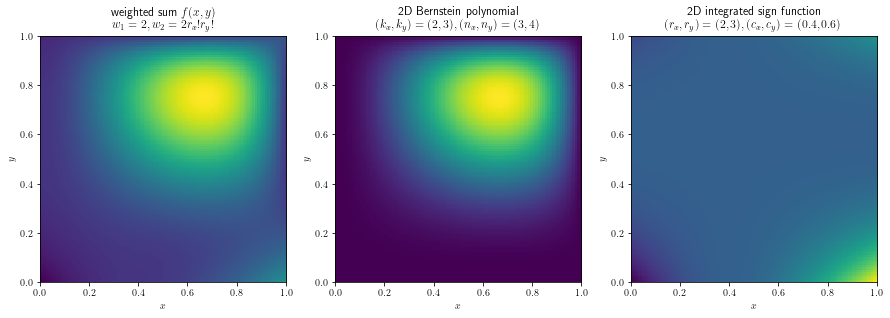

In [13]:
# setup domain and plotting grid points
domain = [0.0, 1.0, 0.0, 1.0]
resolution = 100
xs = np.linspace(domain[0], domain[1], resolution)
ys = np.linspace(domain[0], domain[1], resolution)
xgrid, ygrid = np.meshgrid(xs, ys)

k1, k2 = 2, 3
n1, n2 = 3, 4
r1, r2 = 2, 3
c1, c2 = 0.4, 0.6
w1, w2 = 2, 2*np.math.factorial(r1)*np.math.factorial(r2)

#plot 2D Bernstein plus integrated sign function
zs1 = bernstein2d(xgrid, ygrid, (k1, k2), (n1, n2))
zs2 = signpoly(xgrid-c1, r1)*signpoly(ygrid-c2, r2)
zs = w1 * zs1 + w2 * zs2

plt.figure(figsize=(15,6))


plt.subplot(1,3,1)
plt.imshow(zs, extent=domain, origin='lower')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('weighted sum $f(x, y)$ \n $w_1 = 2, w_2 = 2 r_x! r_y!$');

plt.subplot(1,3,2)
plt.imshow(zs1, extent=domain, origin='lower')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('2D Bernstein polynomial \n $(k_x, k_y) = (2, 3), (n_x, n_y) = (3, 4)$');

plt.subplot(1,3,3)
plt.imshow(zs2, extent=domain, origin='lower')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('2D integrated sign function \n $(r_x, r_y) = (2, 3), (c_x, c_y) = (0.4, 0.6)$');